In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
import datetime

In [3]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1

# IMAGE_DIRECTORY = "../Datasets/HandWritten-Nist/dataset"
IMAGE_DIRECTORY = "../Datasets/MergedMNIST/dataset"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
	IMAGE_DIRECTORY,
	labels="inferred",
	label_mode="categorical", # one-hot encoding stuff
	image_size=(28, 28),
	shuffle=True,
	color_mode="grayscale",
)

# Split to train and test 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


Found 814255 files belonging to 47 classes.


I0000 00:00:1732096642.399263   61897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732096643.703080   61897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732096643.703146   61897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732096643.705305   61897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732096643.705364   61897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
# Normalize the dataset prior to the model

def normalize(image, label):
	image = tf.cast(image, tf.float32) / 255.0
	return image, label

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)

In [5]:
# # Configuring the dataset for performance
# # Enable caching and prefetching (overlap preprocessing and model execution while training)
# AUTOTUNE = tf.data.AUTOTUNE

# # Set up a pre-processing function. It is just going to be normalizing here, but
# # that hopefully should save time later?
# def preprocess_image(image, label):
# 	image = image / 255.0
# 	return image, label

# # Cache to disk instead of memory because we got some large datasets
# dataset = dataset.cache('/tmp/dataset_cache')

# # Apply preprocessing
# # dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# # Prefetching..? Gotta be honest, this seems to help but idk how considering all
# # the images are local
# dataset = dataset.prefetch(buffer_size=2)

# train_ds = dataset.shuffle(1000)

# # train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # train_ds = dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# # val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache('/tmp/dataset_cache')
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
model = tf.keras.models.Sequential()

# Hypothesis by doing tanh here stems from
# 1) Observing that LeNet while simple uses it
# 2) The initial layers are looking for general features, not specific ones
model.add(tf.keras.layers.Conv2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.tanh,
))

# Batch normalizationhelps helps train models faster. It does this in a few
# ways. It allows us (1) to increase the learning rate (2) it helps resolve the
# vanishing gradient problem (usually done by ReLU though) (3) regularization
# which helps prevent overfitting
# https://arxiv.org/abs/1502.03167
# https://www.geeksforgeeks.org/what-is-batch-normalization-in-cnn/#how-does-batch-normalization-work-in-cnn
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2)
))


# Hypothesis by doing relu here is that this layer is going to be looking for
# more abstract features and they should be an off/on situation
model.add(tf.keras.layers.Conv2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
))

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

# LeNet uses 120 neurons, online example uses 128
model.add(tf.keras.layers.Dense(
    units=120,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.2))

# Output layer
model.add(tf.keras.layers.Dense(
    units=47,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

/home/nuttynoah/Downloads/Handwriting-Recognition-CS584/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         5,687 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,047 (156.43 KB)

 Trainable params: 39,999 (156.25 KB)

 Non-trainable params: 48 (192.00 B)

In [9]:
# Compile the model

# Uses Adam. Adam works by
# - Keeping track of a history of gradients as opposed to just the current
#   gradient
# - It uses an adaptive learning rate based on that gradient history Adam is

# It also just generally efficient and works well for our use case (ChatGPT
# mentions good for computer vision tasks which is kind of what we are doing)

# We might try testing this with stochastic gradient descent instead because
# that is what we learned in class. We could use that as a storytelling aspect
# for the professor

# adam_optimizer = tf.keras.optimizers.Adam()
# model.compile(
#     optimizer=adam_optimizer,
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# In past experiments, SGD has performed better and it is apparently used in
# other image networks
# https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
sgd_optimizer = tf.keras.optimizers.SGD()
model.compile(
	optimizer=sgd_optimizer,
	loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    train_dataset,
    # y_train_re,
    epochs=4,
    # validation_data=(x_validation_normalized, y_validation_re),
    validation_data=val_dataset
    # callbacks=[tensorboard_callback]
)

print("The model has successfully trained")

Epoch 1/4


I0000 00:00:1732097039.356771   62373 service.cc:146] XLA service 0x7f9bb8009d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732097039.356822   62373 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1732097055.752822   62373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20356/20356 ━━━━━━━━━━━━━━━━━━━━ 6123s 281ms/step - accuracy: 0.7387 - loss: 0.8858 - val_accuracy: 0.8691 - val_loss: 0.3745
Epoch 2/4
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.8593 - loss: 0.4101 - val_accuracy: 0.8819 - val_loss: 0.3328
Epoch 3/4
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.8718 - loss: 0.3683 - val_accuracy: 0.8841 - val_loss: 0.3199
Epoch 4/4
20356/20356 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8768 - loss: 0.3498 - val_accuracy: 0.8880 - val_loss: 0.3081
The model has successfully trained


In [11]:
# Access training loss and accuracy
train_loss = training_history.history['loss']
train_accuracy = training_history.history['accuracy']

# Access validation loss and accuracy (if validation data is provided)
val_loss = training_history.history.get('val_loss')
val_accuracy = training_history.history.get('val_accuracy')

# Print statistics for each epoch
for epoch in range(len(train_loss)):
    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {train_loss[epoch]:.4f}, Training Accuracy: {train_accuracy[epoch]:.4f}")
    if val_loss and val_accuracy:
        print(f"  Validation Loss: {val_loss[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")

Epoch 1:
  Training Loss: 0.5999, Training Accuracy: 0.8086
  Validation Loss: 0.3745, Validation Accuracy: 0.8691
Epoch 2:
  Training Loss: 0.3970, Training Accuracy: 0.8634
  Validation Loss: 0.3328, Validation Accuracy: 0.8819
Epoch 3:
  Training Loss: 0.3625, Training Accuracy: 0.8734
  Validation Loss: 0.3199, Validation Accuracy: 0.8841
Epoch 4:
  Training Loss: 0.3465, Training Accuracy: 0.8779
  Validation Loss: 0.3081, Validation Accuracy: 0.8880


In [12]:
model_name_string = "model_v6_altered_structure"

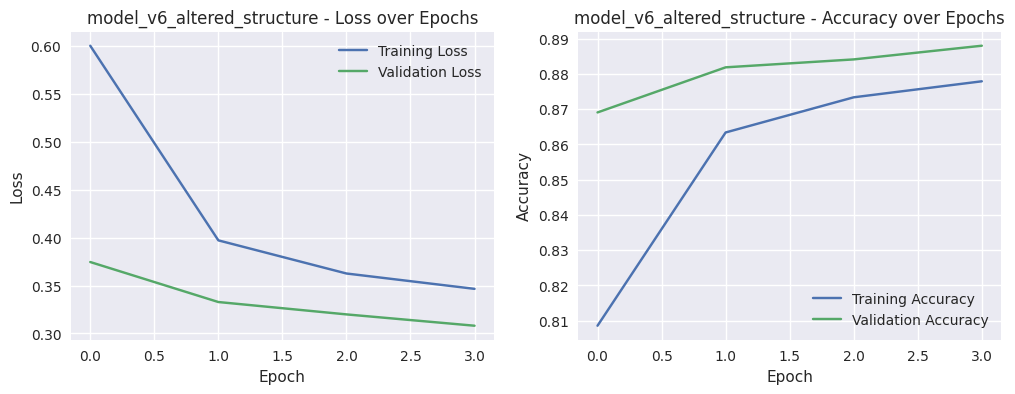

In [13]:
import matplotlib.pyplot as plt


# Plot training and validation loss

with plt.style.context("seaborn-v0_8"):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['loss'], label='Training Loss')
    if 'val_loss' in training_history.history:
        plt.plot(training_history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name_string} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in training_history.history:
        plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name_string} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.style.use('seaborn-v0_8-bright')
    plt.legend()

    plt.show()

In [14]:
import pandas as pd

# Convert the history to a DataFrame and save as CSV
history_df = pd.DataFrame(training_history.history)
history_df.to_csv(f'{model_name_string}_history.csv', index=False)

In [15]:
# Save the model itself
model.save(f'{model_name_string}.keras')

In [16]:
# Save model weights
model.save_weights(f'{model_name_string}.weights.h5') 